In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import codecs
import re
import os
import pickle
import seaborn as sn
import networkx as nx
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec
from gensim  import models

def keyword_count(keywords,Data):
    output = []
    for data in Data:
        output.append([data.count(keyword) for keyword in keywords])    
    return output

def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df


# Read Data from 10-K Data Handling

In [2]:
Company = []
#Company = ['GOOGL','AMZN','JPM']

with open('./Nomura_Report/Available.pkl', 'rb') as f:
    Company = pickle.load(f)

Data = []
for company in Company:
    path    = './10-K Data/sec_edgar_filings/'+company
    dic     = {}

    for dirPath, dirNames, fileNames in os.walk(path):
        for f in fileNames:
            if bool(re.search(r"pkl$",f)):
                year = int(re.findall(r"\d+",f)[0])
                dic[year] = os.path.join(dirPath, f)

    for year in dic:
        try:
            with open(dic[year], 'rb') as f:
                data = pickle.load(f)
                if len(data) != 0: 
                    Data.append([year,company,data])
                else:
                    print('No Data at '+company+' in',year)
        except:
            print('No Data at '+company+' at',year)
    

In [3]:
df_content = pd.DataFrame(Data,columns=['Year', 'Company', 'Content'])
print('Total Nomura Report Company :',len(Company))
print('=====================================')
for year in range(2013,2020):
    print('Total Available Data at '+str(year)+' are ',len(df_content[df_content['Year'] == year]))

Total Nomura Report Company : 67
Total Available Data at 2013 are  4
Total Available Data at 2014 are  12
Total Available Data at 2015 are  33
Total Available Data at 2016 are  33
Total Available Data at 2017 are  34
Total Available Data at 2018 are  33
Total Available Data at 2019 are  25


In [4]:
df_content.head()

,Year,Company,Content
0,2014,MU,"[corporate, information, micron, delaware, cor..."
1,2015,MU,"[overview, micron, technology, inc., including..."
2,2016,MU,"[following, discussion, contains, trend, infor..."
3,2017,MU,"[overview, manufacture, product, worldwide, wh..."
4,2018,MU,"[overview, manufacture, product, wholly-owned,..."


# For Specific Year

In [56]:
YEAR = 2018
keywords_num = 20
# Find Keyword
fdist_content = nltk.FreqDist(sum(df_content['Content'],[]))
df_fdist_content  = pd.DataFrame.from_dict(fdist_content, orient='index')
df_fdist_content.columns = ['Counts']
df_fdist_content  = df_fdist_content.sort_values(by=['Counts'], ascending=False)
keywords = list(df_fdist_content[:keywords_num].index)
keywords_count = list(df_fdist_content[:keywords_num]['Counts'])

In [57]:
filtered_content = list(df_content[df_content['Year'] == YEAR]['Content'])
count = keyword_count(keywords,filtered_content)
table = pd.DataFrame(count,columns = keywords, index = list(df_content[df_content['Year'] == YEAR]['Company']))
table.head()

,business,operation,service,financial,million,cost,cash,market,tax,including,asset,year,company,customer,product,operating,revenue,change,sale,certain
MU,105,116,26,95,20,98,54,61,60,63,24,22,10,106,270,29,33,30,69,63
ARMK,141,78,119,88,89,86,52,24,52,59,37,33,28,16,34,32,43,33,15,68
ERI,112,137,54,75,138,71,89,77,109,90,87,139,57,64,3,87,92,63,42,93
WDC,1,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
FDC,1,1,0,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0


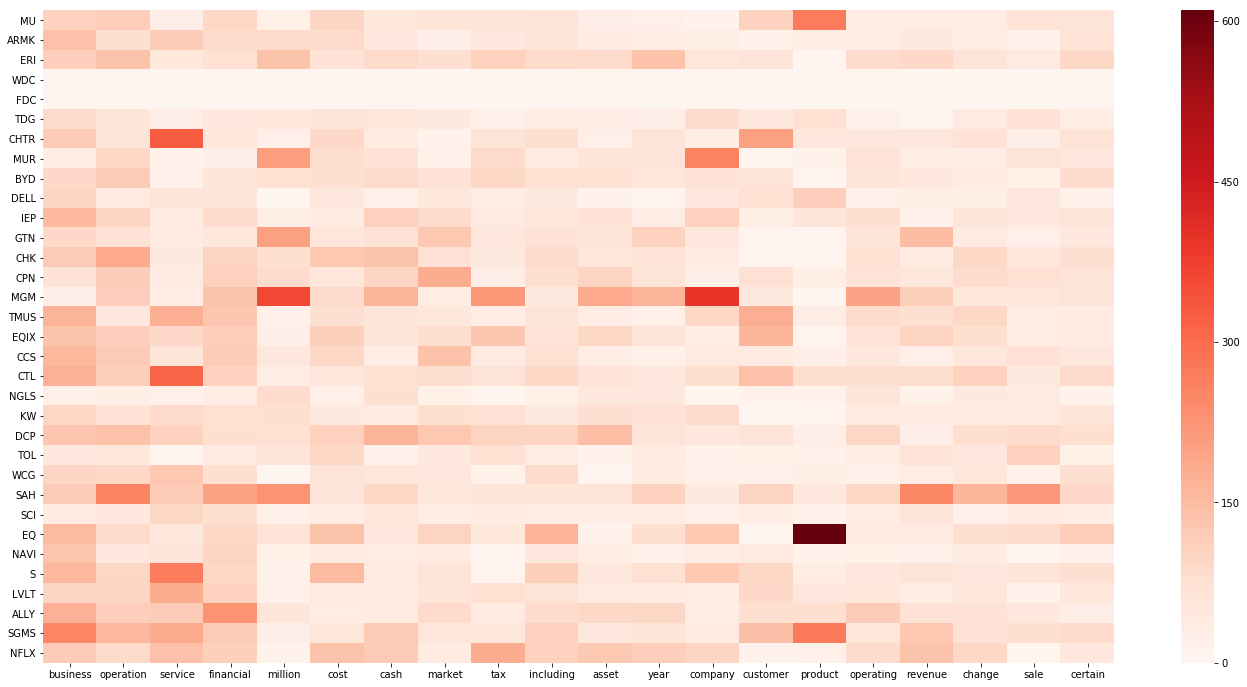

In [58]:
plt.figure(figsize=(24,12))
sn.heatmap(table,cmap='Reds')
plt.show()

In [110]:
CoorMatrix.to_numpy().max()

47495529

In [111]:
CoorMatrix = table.transpose().dot(table)
CoorMatrix_normalize = np.divide(CoorMatrix,CoorMatrix.to_numpy().max())

#min_max_scaler = preprocessing.MinMaxScaler()
#normalizer = preprocessing.Normalizer().fit(CoorMatrix.to_numpy())
#CoorMatrix_normalize = normalizer.transform(CoorMatrix)
#CoorMatrix_normalize = pd.DataFrame(min_max_scaler.fit_transform(CoorMatrix),columns = keywords, index = CoorMatrix.index)
#CoorMatrix_normalize = pd.DataFrame(preprocessing.normalize(CoorMatrix,axis=0),columns = keywords, index = CoorMatrix.index)


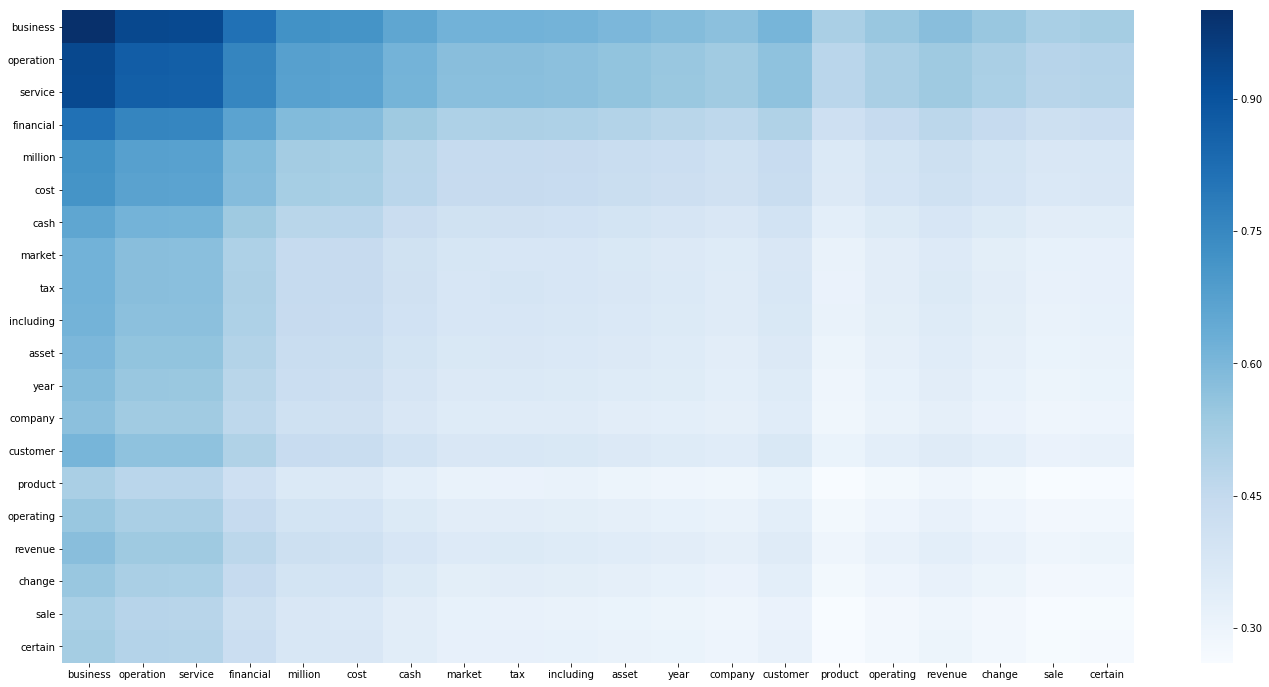

In [112]:
plt.figure(figsize=(24,12))
sn.heatmap(CoorMatrix_normalize,cmap='Blues')
plt.show()

In [113]:
high_cor_list = []
for col_index in CoorMatrix_normalize.columns:
    for row_index in CoorMatrix_normalize.columns:
        if CoorMatrix[col_index][row_index] > 0:
            high_cor_list.append((col_index,row_index,CoorMatrix.loc[col_index][row_index]))

In [114]:
G_title = nx.Graph()
G_title.add_weighted_edges_from(high_cor_list)

C:\Users\Gunther\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Gunther\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


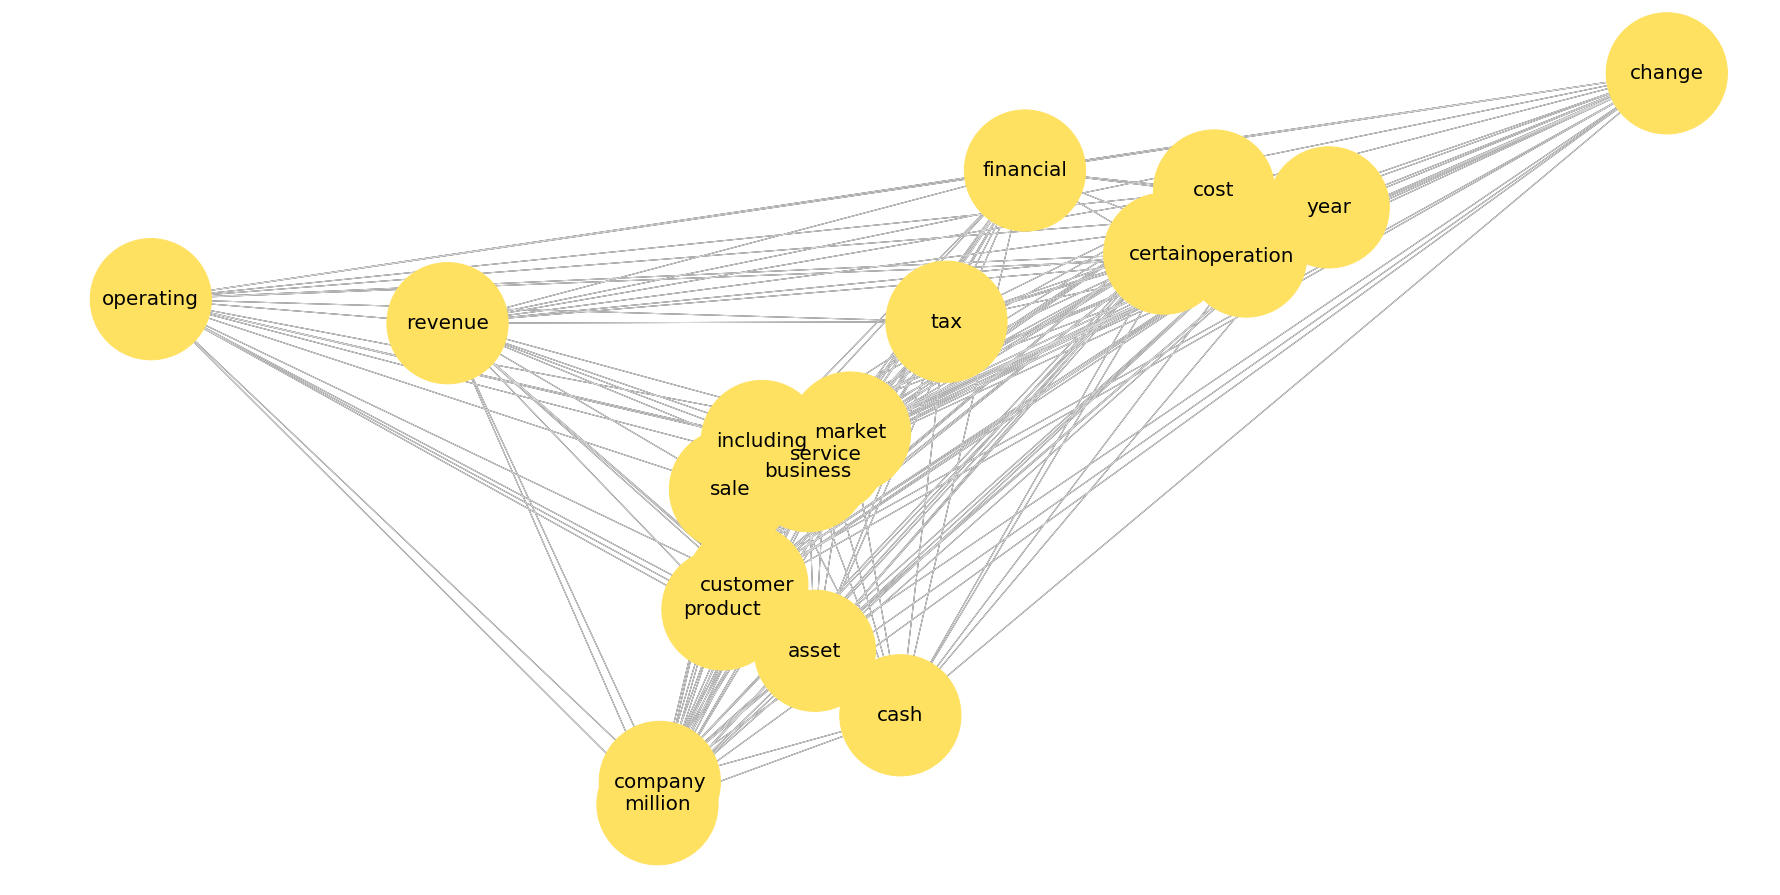

In [115]:
plt.figure(figsize=(24,12))
pos = nx.spring_layout(G_title)
nx.draw(G_title,pos,node_size = [val*700 for (node, val) in G_title.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(G_title, pos, font_size = 20,alpha = 1)
nx.draw_networkx_edges(G_title, pos, edge_color = '#DDDDDD', alpha = 1)
plt.show()

In [116]:
for keyword,val in G_title.degree():
    print(keyword + ' : ' + str(val) + ' Degree')

business : 21 Degree
operation : 21 Degree
service : 21 Degree
financial : 21 Degree
million : 21 Degree
cost : 21 Degree
cash : 21 Degree
market : 21 Degree
tax : 21 Degree
including : 21 Degree
asset : 21 Degree
year : 21 Degree
company : 21 Degree
customer : 21 Degree
product : 21 Degree
operating : 21 Degree
revenue : 21 Degree
change : 21 Degree
sale : 21 Degree
certain : 21 Degree


In [66]:
model = Word2Vec(df_content[df_content['Year'] == YEAR]['Content'],size=250, iter=10, sg=0, min_count=5, max_vocab_size=None)
most_similar(model, keywords, topn=10)

,business,cos,operation,cos,service,cos,financial,cos,million,cos,...,operating,cos,revenue,cos,change,cos,sale,cos,certain,cos
0,operation,0.728048,business,0.728048,wireless,0.689651,prospect,0.708102,billion,0.841336,...,operation,0.678843,profit,0.828063,favorable/,0.737206,selling,0.712567,licensing,0.684353
1,prospect,0.722845,operating,0.678843,wireline,0.682001,discussion,0.691958,contribution,0.826244,...,seasonality,0.610170,membership,0.731006,climate,0.692187,home,0.689072,limitation,0.682097
2,strength,0.693686,harmed,0.607045,provider,0.673725,forward-looking,0.641427,principally,0.824507,...,profit,0.587484,gross,0.728487,economy,0.678421,installment,0.679380,creditor,0.656233
3,reputation,0.672526,continuing,0.600869,customer,0.663426,analysis,0.634364,partially,0.815450,...,revenue,0.578575,profitability,0.712012,likelihood,0.653301,aftermarket,0.679267,customary,0.638794
4,harmed,0.671321,prospect,0.599778,client,0.639531,actually,0.626263,approximately,0.814239,...,gross,0.562885,earned,0.706990,outlook,0.652532,preneed,0.674573,engage,0.630173
5,key,0.669525,inc.management,0.552172,video,0.638997,inc.management,0.624494,offset,0.792488,...,adjusted,0.557608,cnbu,0.688601,uncertain,0.642715,retail,0.673303,relating,0.629097
6,strategy,0.639640,financial,0.531248,internet,0.629385,liquidity,0.621246,noncash,0.774416,...,net,0.552096,margin,0.685132,nature,0.642257,vehicle,0.662994,exception,0.628693
7,success,0.635878,adverse,0.527931,handset,0.623315,materially,0.596793,aggregate,0.773257,...,continuing,0.548096,maximizing,0.684359,pressure,0.634940,force,0.636435,transfer,0.606604
8,managing,0.623990,profitability,0.522693,providing,0.623135,accompanying,0.588703,respectively,0.772806,...,expense,0.546224,seasonality,0.681507,trend,0.631301,profit,0.632103,voluntary,0.605114
9,thorough,0.611707,materially,0.517360,voice,0.620576,deteriorate,0.586994,excluding,0.767613,...,non-operating,0.539469,branded,0.670301,unfavorable,0.621639,maximizing,0.625742,restriction,0.603736


# For All Year

In [117]:
Year_content = []
for year in range(2015,2019):
    Year_content.append(sum(list(df_content[df_content['Year'] == year]['Content']),[]))
    
filtered_content = Year_content
count = keyword_count(keywords,filtered_content)
table = pd.DataFrame(count,columns = keywords, index = [year for year in range(2015,2019)])
table.head()

,business,operation,service,financial,million,cost,cash,market,tax,including,asset,year,company,customer,product,operating,revenue,change,sale,certain
2015,3260,3346,3239,2586,2731,2541,2273,2157,2091,2024,2205,2348,1998,1914,1575,1792,1900,1694,1869,1824
2016,3636,3310,3395,2777,2585,2638,2276,2295,1958,2119,2001,1883,1940,2319,1816,1944,1990,1900,1883,1852
2017,3352,3106,3121,2954,2417,2374,2314,1996,2546,2130,2225,1997,1751,2148,1589,1913,2106,2066,1707,1741
2018,3523,3086,3047,2914,2234,2317,2215,2073,1942,2191,1848,1872,2176,1986,2029,1905,1963,1897,1627,1785


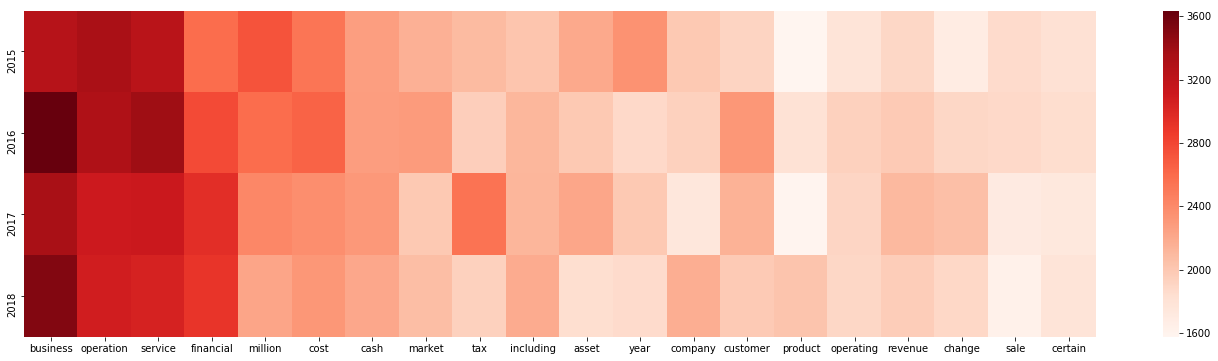

In [118]:
plt.figure(figsize=(24,6))
sn.heatmap(table,cmap='Reds')
plt.show()

In [119]:
CoorMatrix = table.transpose().dot(table)
CoorMatrix_normalize = np.divide(CoorMatrix,CoorMatrix.to_numpy().max())
#CoorMatrix_normalize = pd.DataFrame(preprocessing.normalize(CoorMatrix),columns = keywords, index = CoorMatrix.index)

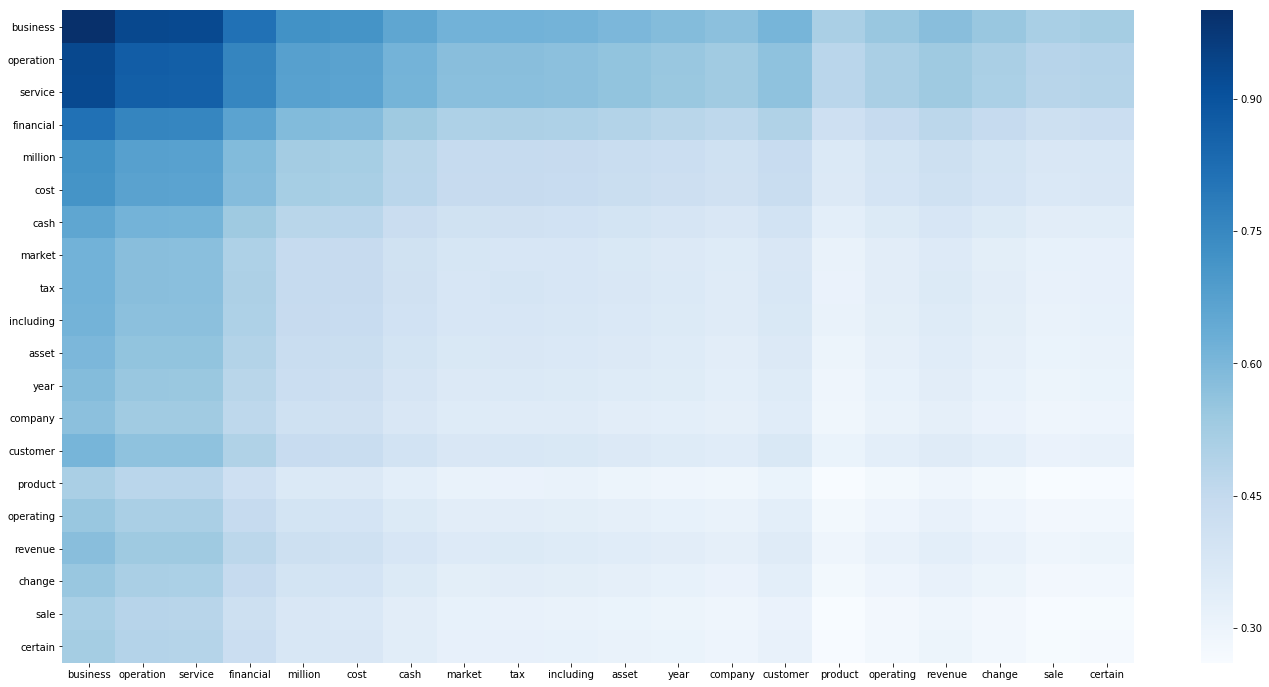

In [121]:
plt.figure(figsize=(24,12))
sn.heatmap(CoorMatrix_normalize,cmap='Blues')
plt.show()

In [122]:
high_cor_list = []
for col_index in CoorMatrix_normalize.columns:
    for row_index in CoorMatrix_normalize.columns:
        if CoorMatrix[col_index][row_index] > 0:
            high_cor_list.append((col_index,row_index,CoorMatrix.loc[col_index][row_index]))

C:\Users\Gunther\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Gunther\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


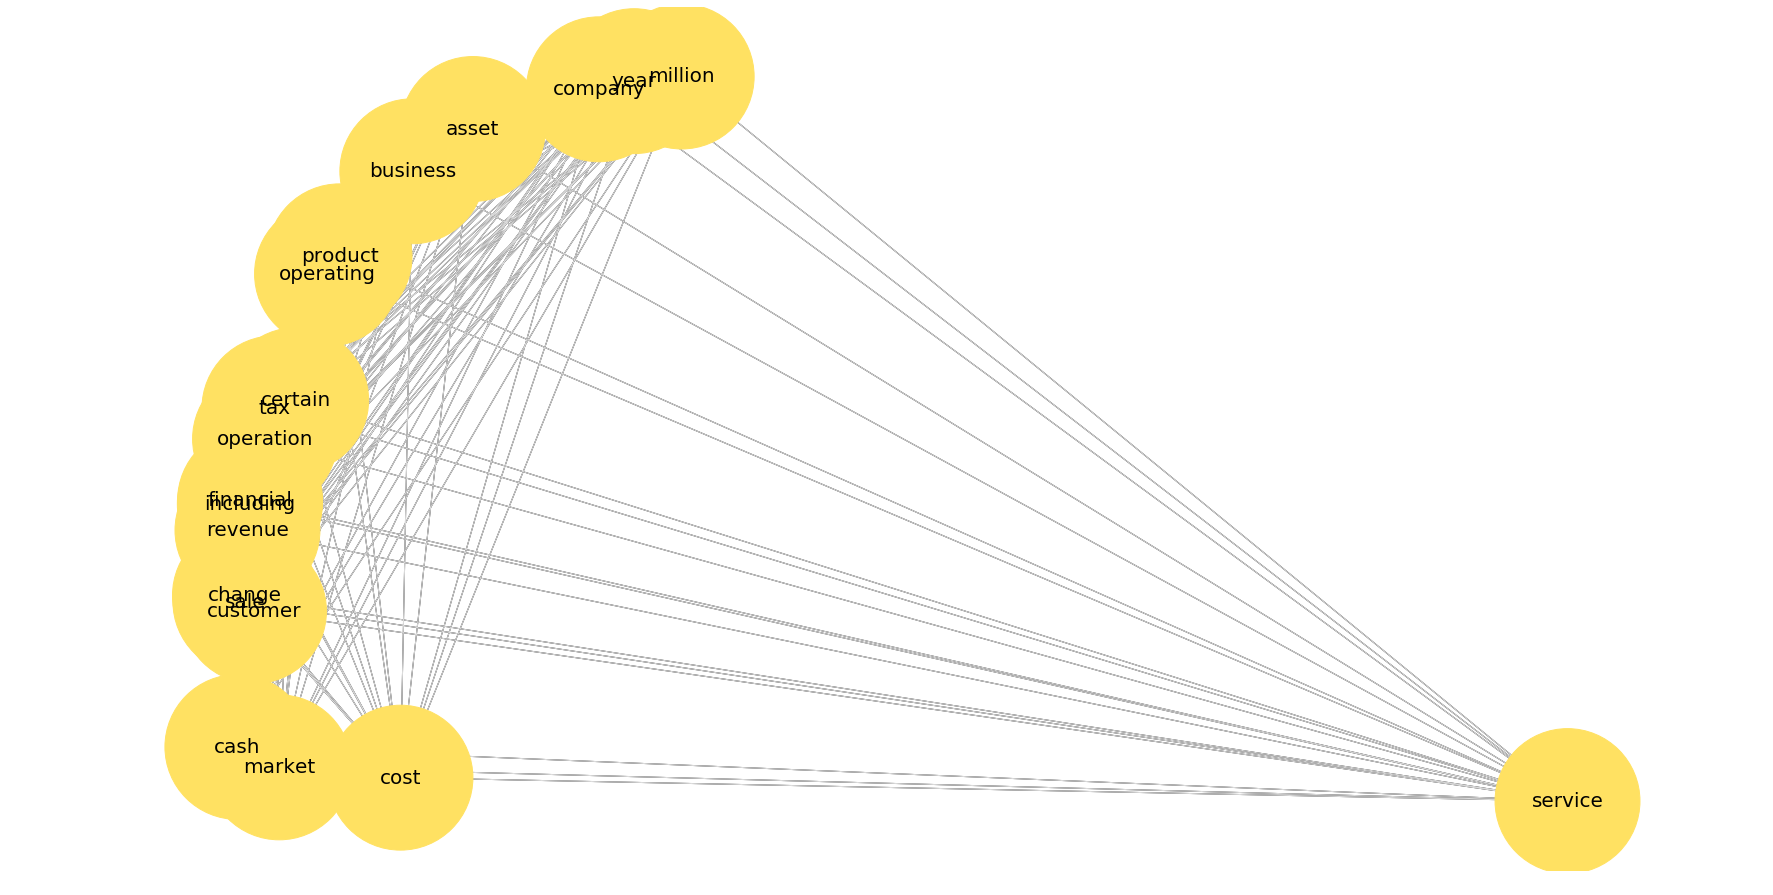

In [123]:
G_title = nx.Graph()
G_title.add_weighted_edges_from(high_cor_list)
plt.figure(figsize=(24,12))
pos = nx.spring_layout(G_title)
nx.draw(G_title,pos,node_size = [val*1000 for (node, val) in G_title.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(G_title, pos, font_size = 20,alpha = 1)
nx.draw_networkx_edges(G_title, pos, edge_color = '#DDDDDD', alpha = 1)
plt.show()

In [124]:
for keyword,val in G_title.degree():
    print(keyword + ' : ' + str(val) + ' Degree')

business : 21 Degree
operation : 21 Degree
service : 21 Degree
financial : 21 Degree
million : 21 Degree
cost : 21 Degree
cash : 21 Degree
market : 21 Degree
tax : 21 Degree
including : 21 Degree
asset : 21 Degree
year : 21 Degree
company : 21 Degree
customer : 21 Degree
product : 21 Degree
operating : 21 Degree
revenue : 21 Degree
change : 21 Degree
sale : 21 Degree
certain : 21 Degree


In [125]:
model = Word2Vec(Year_content,size=250, iter=10, sg=0, min_count=5,max_vocab_size=None)
most_similar(model, keywords, topn=10)

,business,cos,operation,cos,service,cos,financial,cos,million,cos,...,operating,cos,revenue,cos,change,cos,sale,cos,certain,cos
0,harm,0.998831,effect,0.997965,third-party,0.998792,concentration,0.993807,principal,0.993692,...,expense,0.996404,representative,0.998678,associated,0.998512,compared,0.997405,trustee,0.999114
1,impact,0.997943,turn,0.996255,broad,0.998683,bear,0.991863,equity,0.993365,...,accrued,0.991670,independent,0.998619,assessment,0.998261,due,0.997172,acquiring,0.999047
2,vulnerability,0.997799,adverse,0.995800,component,0.998441,conformity,0.991818,inotera,0.992369,...,ended,0.988629,ten,0.997984,exposure,0.997885,declined,0.996919,imposes,0.998961
3,affected,0.997654,economic,0.994960,provider,0.998395,unresolved,0.990907,repurchase,0.989987,...,total,0.988418,decrease,0.997726,goodwill,0.997549,mbu,0.996885,coverage,0.998716
4,economic,0.997001,materially,0.991715,environmental,0.998313,exchange,0.990041,remainder,0.989936,...,attributable,0.988111,improve,0.997563,sab,0.996888,volume,0.996644,provide,0.998714
5,advisable,0.996930,interaction,0.990709,meet,0.998263,company-wide,0.984265,proceeds,0.989900,...,cnbu,0.984618,commensurate,0.997173,attention,0.996825,ebu,0.996081,operate,0.998654
6,typical,0.996502,material,0.990135,source,0.997848,constraint,0.983272,outstanding,0.989269,...,noncontrolling,0.984043,pc,0.996902,institution,0.996493,increased,0.995984,joint,0.998543
7,foregoing,0.995209,condition,0.989069,leisure,0.997815,qualitative,0.982728,conversion,0.989215,...,investing,0.983934,overall,0.996688,difficult,0.996352,primarily,0.995801,strategic,0.998457
8,reluctant,0.994821,central,0.988669,carrier,0.997704,comment,0.981899,amount,0.989105,...,realizable,0.983492,cost,0.996684,formation,0.995883,resulting,0.995570,however,0.998413
9,negatively,0.994603,impact,0.988398,also,0.997525,selected,0.981557,aggregate,0.989053,...,mbu,0.982959,potentially,0.996486,depends,0.995799,margin,0.995256,remains,0.998406
